# libraries

In [1]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import en_core_web_sm
from spacy.matcher import Matcher
from spacy.matcher import PhraseMatcher
from spacy import displacy


%matplotlib inline

# to import Database class from data_collection folder
module_path = os.path.abspath(os.path.join('../..')+'/data/data_collection')
if module_path not in sys.path:
    sys.path.append(module_path)

# now that the folder is in the path, ../data_collection/database.py can be imported
from database import Database

# Import reviews data and target feature

In [2]:
db = Database()

# get halal-reviews (reviews that include the word 'halal')
reviews_sql = '''SELECT * FROM reviews'''
reviews_df = db.select_df(reviews_sql)
print('- {} reviews containing the word halal were scraped'.format(reviews_df.shape[0]))

# get target restaurants-of-interest list 
file_path = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/target_feature/label_target.csv'
target_df = pd.read_csv(file_path, index_col=0)
target_df['halal'] = target_df['halal'].str.replace('FLASE', 'FALSE')
target_df['halal'] = target_df['halal'].apply(lambda x: True if x =='TRUE' else False)
halal_frac = target_df['halal'].sum()/target_df.shape[0]

print('- {:.0f}% of the {} restaurants-of-interest are halal'.format(halal_frac*100, target_df.shape[0]))

- 5092 reviews containing the word halal were scraped
- 73% of the 838 restaurants-of-interest are halal


# Feature Engineering
## 1. 'halal' in business name

In [3]:
# patch missing platform_ids and mismatch in target data

# import original businesses data
rest_sql = '''SELECT * FROM businesses WHERE url LIKE '%yelp%' '''
rest_df = db.select_df(rest_sql)

# drop Aya Kitchen
aya_id = 'y6BfLt9Gvrq2JsJvjkjdIQ'
reviews_df.drop(reviews_df[reviews_df['restaurant_id'] == aya_id].index, inplace=True)

# patch platform_id in target_df
target_df = target_df.merge(rest_df[['platform_id', 'url']], how='left', on='url')
target_df.drop('platform_id_x', inplace=True, axis=1)
target_df = target_df.rename(columns={'platform_id_y' : 'platform_id'})

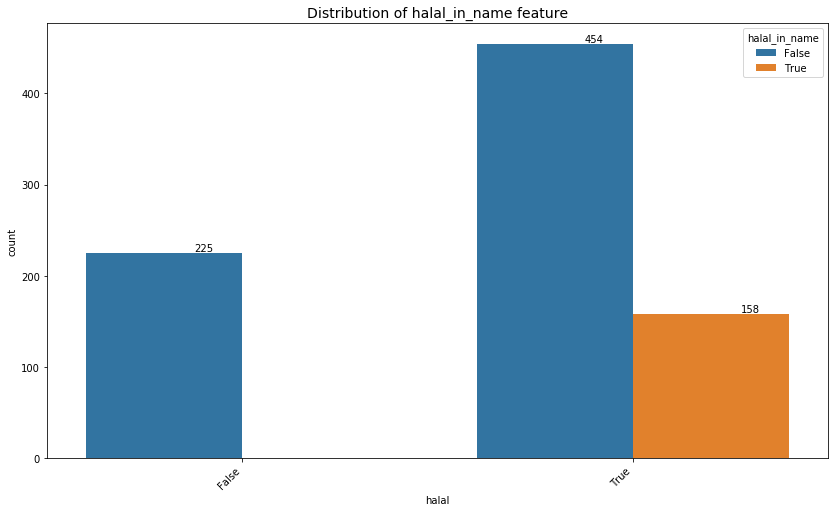

In [4]:
# group reviews per restaurant
grouped_reviews_df = reviews_df.groupby('restaurant_id').agg(lambda x: ' '.join(x)) # combine review text
grouped_reviews_df['review_date'] = grouped_reviews_df['review_date'].apply(lambda x: x.split()) # make dates list
grouped_reviews_df['review_count'] = grouped_reviews_df['review_date'].apply(lambda x: len(x)) # count reviews per restaurnat
grouped_reviews_df.head()

# merge restaurant name 
grouped_reviews_df = grouped_reviews_df.merge(target_df[['platform_id', 'name', 'total_review_count', 'halal']], how='left', left_index=True, right_on='platform_id')

grouped_reviews_df.index = grouped_reviews_df['platform_id']
grouped_reviews_df.drop('platform_id', inplace=True, axis=1)
grouped_reviews_df = grouped_reviews_df.rename(columns={'name': 'restaurant_name', 'review_count' : 'halal_review_count'})

# add boolean column for 'halal' in restaurant name
grouped_reviews_df['halal_in_name'] = grouped_reviews_df.apply(lambda row: True if 'halal' in row['restaurant_name'].lower() else False, axis=1)

plt.figure(figsize=(14,8))
g = sns.countplot(x='halal', hue='halal_in_name', data=grouped_reviews_df)
g.set_title('Distribution of halal_in_name feature', size=14)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom', color= 'black')

## 2. Percentage of reviews including the word halal out of all reviews

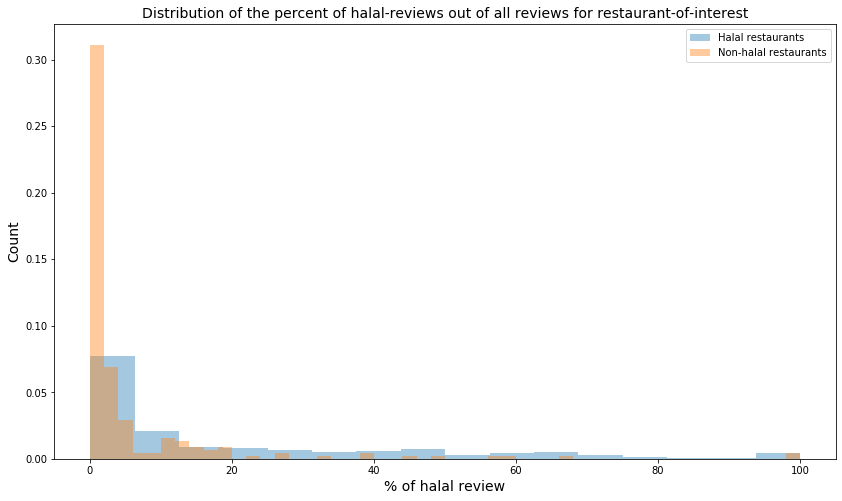

In [5]:
# calculate percentage of halal-containing reviews out of total reviews
grouped_reviews_df['halal_review_percent'] = grouped_reviews_df.apply(lambda row: row['halal_review_count']/row['total_review_count'], axis =1)

# plot distribution for halal vs non-halal restaurants
halal_target = grouped_reviews_df[grouped_reviews_df['halal']]['halal_review_percent']
non_halal_target = grouped_reviews_df[~grouped_reviews_df['halal']]['halal_review_percent']
fig = plt.figure(figsize=(14,8))
g1 = sns.distplot(halal_target*100, kde=False, norm_hist=True)
g2 = sns.distplot(non_halal_target*100, kde=False, norm_hist=True)
g1.set_title('Distribution of the percent of halal-reviews out of all reviews for restaurant-of-interest', size=14)
g1.set_xlabel('% of halal review', size=14)
g1.set_ylabel('Count', size=14)
plt.legend(labels=['Halal restaurants','Non-halal restaurants'], prop={'size': 10})
plt.show()

In [6]:
grouped_reviews_df[(grouped_reviews_df['halal_review_percent'] > 0.9) & (~grouped_reviews_df['halal'])]

,review_text,review_date,halal_review_count,restaurant_name,total_review_count,halal,halal_in_name,halal_review_percent
platform_id,,,,,,,,
OLEjsQZtBDLRdiLe19o4fg,"Be careful while eating here, they say everyth...","[3/2/2020, 1/29/2020]",2,Airport Deli,2,False,False,1.0
eoxv_U5MOY8qcSvPTY1HSw,I came uptown to meet 2 friends for a get toge...,"[1/8/2020, 1/21/2020]",2,Chapati Man NY,2,False,False,1.0


- The higher percentage of halal-related reviews in non-halal restaurants is probably related to food carts or restaurants with few reviews to start with and they have comparison to halal-guys or halal street cuisine 

## 3. Spacy nlp
### 3.1. Includes halal-relevant terms
- List of halal-relevant terms: [{LEMMA: be},{LOWER: halal}], [{LOWER: halal}, {LOWER: meat/options/chicken/beef/lamb/spot/restaurant/burger}]

In [7]:
## run nlp of grouped review text and save Doc to dataframe
nlp = en_core_web_sm.load()
grouped_reviews_df['doc'] = grouped_reviews_df['review_text'].apply(lambda x: nlp(x))

# initialize phrase matcher
matcher = PhraseMatcher(nlp.vocab)

# # specify match pattern for matcher
# pattern1 = [{'LEMMA': 'be'},{'LOWER': 'halal'}]
# pattern2 = [{'LOWER': 'halal'},{'LOWER': 'meat'}]
# pattern3 = [{'LOWER': 'halal'},{'LOWER': 'beef'}]
# pattern4 = [{'LOWER': 'halal'},{'LOWER': 'lamb'}]
# pattern5 = [{'LOWER': 'halal'},{'LOWER': 'chicken'}]
# pattern6 = [{'LOWER': 'halal'},{'LOWER': 'burger'}]
# pattern7 = [{'LOWER': 'halal'},{'LOWER': 'options'}]
# pattern8 = [{'LOWER': 'halal'},{'LOWER': 'place'}]
# pattern9 = [{'LOWER': 'halal'},{'LOWER': 'spot'}]
# pattern10 = [{'LOWER': 'halal'},{'LOWER': 'restaurant'}]
# matcher.add('be_halal', None, pattern1)

matcher.add('halal', None, nlp('is halal'), nlp("'s halal"), nlp('halal meat'), nlp('halal beef'),
            nlp('halal lamb'), nlp('halal goat'), nlp('halal chicken'), nlp('halal burger'), 
            nlp('halal options'), nlp('halal place'), nlp('halal spot'), nlp('halal restaurant'))

# match and print the first few setences
c=10
for i, doc in grouped_reviews_df['doc'].iteritems():
    match = matcher(doc)
    count = len(match)
    grouped_reviews_df.loc[i, 'halal_relevant_count'] = count
    grouped_reviews_df.loc[i, 'halal_relevant'] = True if count>0 else False
    if c>0:
        for match_id, start, end in match:
            print('{}:'.format(i), doc[start:end].sent)
        c -= 1

-E5PfobEXNQ_WC8Qv2wGJA: a halal place would do this... they will surely be out of business at this rate
-E5PfobEXNQ_WC8Qv2wGJA: This one is completely up to par with the infamous Fatima's halal kitchen and so much better than Sagar's Chinese if we're going to compare halal Chinese food.

-E5PfobEXNQ_WC8Qv2wGJA: Love this place and love that it's halal.
-QIPdiq5ILg_EJqdVoCqEA: I wanted a halal place around my hotel
-QIPdiq5ILg_EJqdVoCqEA: Love that it's halal and delicious.
-QIPdiq5ILg_EJqdVoCqEA: The entire menu is halal and although they do not serve alcohol, you are welcome bring your own.
-QIPdiq5ILg_EJqdVoCqEA: This is the first halal restaurant I've seen in Manhattan.
-QIPdiq5ILg_EJqdVoCqEA: It's good to find a halal place in NYC.
-QVywSt3181U8ZGkUF-h7Q: I have asked them verbally three times if their meat is halal
-QVywSt3181U8ZGkUF-h7Q: , everything is halal.
-QVywSt3181U8ZGkUF-h7Q: both times was told again yes - everything is halal.


-QVywSt3181U8ZGkUF-h7Q: If you only have a

In [8]:
# visualize presence of halal_relevant terms vs target feature
pd.crosstab(grouped_reviews_df['halal'], grouped_reviews_df['halal_relevant'])

halal_relevant,False,True
halal,,
False,165,60
True,275,337


### 3.2. Includes negation of halal

In [9]:
# look for negation tokens. Then check if halal is in token.head or token.children
# print first few results
c=5
for i, doc in grouped_reviews_df['doc'].iteritems():
    grouped_reviews_df.loc[i, 'halal_negation_count'] = 0
    grouped_reviews_df.loc[i, 'halal_negation'] = False
    for token in doc:
        # for negation tokens, check if 'halal' is in token.head or children
        if (token.dep_ == 'neg') & ((token.head.text.lower() == 'halal') | ('halal' in [child.text.lower() for child in token.head.children])):
            grouped_reviews_df.loc[i, 'halal_negation'] = True
            grouped_reviews_df.loc[i, 'halal_negation_count'] = grouped_reviews_df.loc[i, 'halal_negation_count'] + 1
            if c>0:
                sent = doc[token.i: token.i+1].sent
                print('\n',sent)
                print('Head is: {}'.format(token.head), token.head.pos_)
                print('Children list:', *[child.text for child in token.head.children])
                print('Children list:', *[child.pos_ for child in token.head.children])
                c-=1


 They have a halal sign clearly visible at the entrance of those store however they are NOT fully halal.
Head is: are AUX
Children list: however they NOT halal
Children list: ADV PRON ADV NOUN

 well...no our cold cuts are not halal".
Head is: are AUX
Children list: well no cuts not halal " .
Children list: ADV DET NOUN PART NOUN PUNCT PUNCT

 If I remember correctly, the duck was not halal in their first restaurant.
Head is: was AUX
Children list: remember , duck not halal in .
Children list: VERB PUNCT NOUN PART NOUN ADP PUNCT

 , I don't normally eat Halal
Head is: eat VERB
Children list: , I do n't normally Halal
Children list: PUNCT PRON AUX PART ADV PROPN

 was like pork meat they are not halal
Head is: are AUX
Children list: they not halal
Children list: PRON PART PROPN


In [10]:
# visualize halal negation vs. target feature
pd.crosstab(grouped_reviews_df['halal'], grouped_reviews_df['halal_negation'])

halal_negation,False,True
halal,,
False,192,33
True,544,68


### 3.3. Incidences of 'halal guys'/ 'halal truck'

In [11]:
# initialize phrase matcher
matcher = PhraseMatcher(nlp.vocab)

# add phrases
matcher.add('halal', None, nlp('halal guys'), nlp('halal truck'))

# match and print the first few setences
c=10
for i, doc in grouped_reviews_df['doc'].iteritems():
    match = matcher(doc)
    count = len(match)
    grouped_reviews_df.loc[i, 'halal_truck_count'] = count
    grouped_reviews_df.loc[i, 'halal_truck'] = True if count>0 else False
    if c>0:
        for match_id, start, end in match:
            print('{}:'.format(i), doc[start:end].sent)
        c -= 1

-GYT90fOCNjTbjCjj4wuiw: This is he halal truck that made me fall in love with halal trucks!
-GYT90fOCNjTbjCjj4wuiw: Quick, better than halal guys, and have a magical green sauce.
-KZ94Orpimvy6a9kMgNgWQ: The halal guys at midtown are only good for quantity, and considering how they charge you $7, I think the price to quantity ratio is about the same.  


In [12]:
pd.crosstab(grouped_reviews_df['halal'], grouped_reviews_df['halal_truck'])

halal_truck,False,True
halal,,
False,184,41
True,514,98


### 3.4. Includes non-halal terms
- List of non-halal terms: pork, bacon, ham, alcohol, beer, wine, shortening, lard, geltin

In [13]:
# initialize matcher
matcher = Matcher(nlp.vocab)

# add pattern
pattern1 = [{'LOWER': 'pork'}]; matcher.add('non-halal', None, pattern1)
pattern2 = [{'LOWER': 'bacon'}]; matcher.add('non-halal', None, pattern2)
pattern3 = [{'LOWER': 'ham'}]; matcher.add('non-halal', None, pattern3)
pattern4 = [{'LOWER': 'alcohol'}]; matcher.add('non-halal', None, pattern4)
pattern5 = [{'LOWER': 'beer'}]; matcher.add('non-halal', None, pattern5)
pattern6 = [{'LOWER': 'wine'}]; matcher.add('non-halal', None, pattern6)
pattern7 = [{'LOWER': 'shortening'}]; matcher.add('non-halal', None, pattern7)
pattern8 = [{'LOWER': 'lard'}]; matcher.add('non-halal', None, pattern8)
pattern9 = [{'LOWER': 'gelatin'}]; matcher.add('non-halal', None, pattern9)
pattern10 = [{'LOWER': 'bar'}]; matcher.add('non-halal', None, pattern10)

# match and print the first few setences
c=10
for i, doc in grouped_reviews_df['doc'].iteritems():
    match = matcher(doc)
    count = len(match)
    grouped_reviews_df.loc[i, 'non_halal_relevant_count'] = count
    grouped_reviews_df.loc[i, 'non_halal_relevant'] = True if count>0 else False
    if c>0:
        for match_id, start, end in match:
            print('{}:'.format(i), doc[start:end].sent)
        c -= 1

-6tSx9IXwt1btreBtcyZ0g: Great drink beer and cider selection and delicious food.
-6tSx9IXwt1btreBtcyZ0g: and we have always found the service really friendly, whether there for drinks and the bar or sitting in the back with a kid in a high chair.
-6tSx9IXwt1btreBtcyZ0g: The bar has a good vibe to chill and the beer is spot on.
-6tSx9IXwt1btreBtcyZ0g: The bar has a good vibe to chill and the beer is spot on.
-6tSx9IXwt1btreBtcyZ0g: The beer selection is vast and would highly recommend the poutine!
-6tSx9IXwt1btreBtcyZ0g: Staff super friendly and educated about the menu and bar items, really helped with suggestions.

-6tSx9IXwt1btreBtcyZ0g: They have a full service bar, but specialize in great craft beers and one of the hugest list of ciders I have ever seen in one place.
-6tSx9IXwt1btreBtcyZ0g: , roasted pork, char siu sauce, pickled white onion, peanuts pickled lotus root, cilantro.


-6tSx9IXwt1btreBtcyZ0g: maybe next time Great service, great beer, great food.
-6tSx9IXwt1btreBtcyZ0g:

In [14]:
pd.crosstab(grouped_reviews_df['halal'], grouped_reviews_df['non_halal_relevant'])

non_halal_relevant,False,True
halal,,
False,143,82
True,465,147


### 3.5. Includes CreekStone

In [15]:
# initialize matcher
matcher = Matcher(nlp.vocab)

# add pattern
pattern = [{'LOWER': 'creekstone'}]
matcher.add('creekstone', None, pattern)

# match and print the first few setences
c=2
for i, doc in grouped_reviews_df['doc'].iteritems():
    match = matcher(doc)
    count = len(match)
    grouped_reviews_df.loc[i, 'creekstone_count'] = count
    grouped_reviews_df.loc[i, 'creekstone'] = True if count>0 else False
    if count>0 and c>0:
        for match_id, start, end in match:
            print('{}:'.format(i), doc[start:end].sent)
        c -= 1

70qCoYq7tqrzeZIYwpTf5A: Also the chicken is sourced from Goffle and the meat is Creekstone making it halal for all those who are concerned about that.  


DRitJoNGTkHXZvH_YpLIAw: My mother had their Creekstone steak (it's halal!


In [16]:
pd.crosstab(grouped_reviews_df['halal'], grouped_reviews_df['creekstone'])

creekstone,False,True
halal,,
False,219,6
True,609,3


### 3.6. Incidences of beef/ trukey bacon

In [17]:
# initialize matcher
matcher = Matcher(nlp.vocab)

# add pattern
pattern1 = [{'LOWER': 'beef'}, {'LOWER': 'bacon'}]; matcher.add('halal_bacon', None, pattern1)
pattern2 = [{'LOWER': 'turkey'}, {'LOWER': 'bacon'}]; matcher.add('halal_bacon', None, pattern2)

# match and print the first few setences
c=2
for i, doc in grouped_reviews_df['doc'].iteritems():
    match = matcher(doc)
    count = len(match)
    grouped_reviews_df.loc[i, 'hala_bacon_count'] = count
    grouped_reviews_df.loc[i, 'halal_bacon'] = True if count>0 else False
    if count>0 and c>0:
        for match_id, start, end in match:
            print('{}:'.format(i), doc[start:end].sent)
        c -= 1

0UER2Ez09Sn45-pbKAU5Ew: The burgers are affordable and delicious, I get the farmhouse bacon burger with extra beef bacon on my cheat days, I grab the platters after the gym because they are on the healthier side compared to
0UER2Ez09Sn45-pbKAU5Ew: The Farmhouse Beef Bacon burger was fantastic, filling, great flavors, crunchy, everything you want from a better burger.


0UER2Ez09Sn45-pbKAU5Ew: but I would say don't get those Buffalo beef bacon fries cause they come out pretty soggy
0UER2Ez09Sn45-pbKAU5Ew: Y'all need to try this Farmhouse Beef Bacon Burger at Omar's!!
0UER2Ez09Sn45-pbKAU5Ew: It's filled with tomato, fried onions, stacked beef bacon, Swiss cheese and patty on a bun.
0UER2Ez09Sn45-pbKAU5Ew: Everything was excellent, the burger was very juicy, the fries and onion rings were nice and crispy, and the halal beef bacon was delicious.
0UER2Ez09Sn45-pbKAU5Ew: Farmhouse Beef Bacon burger-
0UER2Ez09Sn45-pbKAU5Ew: Juicy patty, salted crispy onions and crunchy beef bacon!
0UER2Ez09Sn

In [18]:
pd.crosstab(grouped_reviews_df['halal'], grouped_reviews_df['halal_bacon'])

halal_bacon,False,True
halal,,
False,224,1
True,598,14


## 4. Pickle dataframe and save it

In [19]:
grouped_reviews_df.columns

Index(['review_text', 'review_date', 'halal_review_count', 'restaurant_name',
       'total_review_count', 'halal', 'halal_in_name', 'halal_review_percent',
       'doc', 'halal_relevant_count', 'halal_relevant', 'halal_negation_count',
       'halal_negation', 'halal_truck_count', 'halal_truck',
       'non_halal_relevant_count', 'non_halal_relevant', 'creekstone_count',
       'creekstone', 'hala_bacon_count', 'halal_bacon'],
      dtype='object')

### 4.1. pickle dataframe with categorial features only

In [20]:
# to_pickle_df = grouped_reviews_df[['halal', 'halal_in_name', 'halal_review_percent', 'halal_relevant',
#                                    'halal_negation', 'halal_truck', 'creekstone', 'non_halal_relevant',
#                                    'halal_bacon']]
# file_name = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/features_draft_1.pkl'
# to_pickle_df.to_pickle(file_name)

### 4.2. pickle dataframe with numerical features only

In [21]:
# to_pickle_df = grouped_reviews_df[['halal', 'halal_in_name', 'halal_review_percent', 'halal_relevant_count',
#                                    'halal_negation_count', 'halal_truck_count','non_halal_relevant_count',
#                                    'creekstone_count', 'hala_bacon_count']]
# file_name = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/features_draft_2.pkl'
# to_pickle_df.to_pickle(file_name)

## 5. Make data frame with individual reviews for classification
- Features to merge from business data:
    - 'halal_in_name'
    - percentage of halal reviews out of total reviews
    - Halal calssification (target)
- Need to figure out a way combine review predictions to a restaurant score

In [22]:
# make sure Aya Kitchen reviews are removed
aya_id = 'y6BfLt9Gvrq2JsJvjkjdIQ'
if aya_id in reviews_df.restaurant_id.unique().tolist():
    reviews_df.drop(reviews_df[reviews_df['restaurant_id'] == aya_id].index, inplace=True)

# merge fatures from grouped_reviews
reviews_df2 = reviews_df.merge(grouped_reviews_df[['halal_in_name', 'halal_review_percent', 'halal']],
                 left_on='restaurant_id', right_index=True)
print('{:.0f}% of the {} reviews are for halal restaurants'.format(reviews_df2.halal.sum()/ reviews_df2.shape[0]*100,
                                                               reviews_df2.shape[0]))

82% of the 5087 reviews are for halal restaurants


In [23]:
# define functions for nlp feature extraction
def is_halal_relevant(doc_col):
    # initialize phrase matcher
    matcher = PhraseMatcher(nlp.vocab)
    # add phrases
    matcher.add('halal', None, nlp('is halal'), nlp("'s halal"), nlp('halal meat'), nlp('halal beef'),
                nlp('halal lamb'), nlp('halal goat'), nlp('halal chicken'), nlp('halal burger'), 
                nlp('halal options'), nlp('halal place'), nlp('halal spot'), nlp('halal restaurant'))
    # phrase match
    res = []
    for i, doc in doc_col.iteritems():
        match = matcher(doc)
        res.append(True if len(match) else False)
    return res

def is_halal_negation(doc_col):
    res = []
    for i, doc in doc_col.iteritems():
        found = False
        for token in doc:
            # for negation tokens, check if 'halal' is in token.head or children
            if (token.dep_ == 'neg') & (token.head.text.lower() == 'halal'):
                res.append(True)
                found = True
                break
            elif (token.dep_ == 'neg') & ('halal' in [child.text.lower() for child in token.head.children]):
                res.append(True)
                found = True
                break
        if not found:
            res.append(False)
    return res

def is_halal_truck(doc_col):
    # initialize phrase matcher
    matcher = PhraseMatcher(nlp.vocab)
    # add phrases
    matcher.add('halal', None, nlp('halal guys'), nlp('halal truck'))
    # phrase match
    res = []
    for i, doc in doc_col.iteritems():
        match = matcher(doc)
        res.append(True if len(match) else False)
    return res

def is_non_halal_relevant_and_count(doc_col):
    # initialize matcher
    matcher = Matcher(nlp.vocab)
    # add patterns
    pattern1 = [{'LOWER': 'pork'}]; matcher.add('non-halal', None, pattern1)
    pattern2 = [{'LOWER': 'bacon'}]; matcher.add('non-halal', None, pattern2)
    pattern3 = [{'LOWER': 'ham'}]; matcher.add('non-halal', None, pattern3)
    pattern4 = [{'LOWER': 'alcohol'}]; matcher.add('non-halal', None, pattern4)
    pattern5 = [{'LOWER': 'beer'}]; matcher.add('non-halal', None, pattern5)
    pattern6 = [{'LOWER': 'wine'}]; matcher.add('non-halal', None, pattern6)
    pattern7 = [{'LOWER': 'shortening'}]; matcher.add('non-halal', None, pattern7)
    pattern8 = [{'LOWER': 'lard'}]; matcher.add('non-halal', None, pattern8)
    pattern9 = [{'LOWER': 'gelatin'}]; matcher.add('non-halal', None, pattern9)
    pattern10 = [{'LOWER': 'bar'}]; matcher.add('non-halal', None, pattern10)
    # match
    bool_list = []
    count = []
    for i, doc in doc_col.iteritems():
        match = matcher(doc)
        bool_list.append(True if len(match) else False)
        count.append(len(match))
    return bool_list, count


def is_creekstone(doc_col):
    # initialize matcher
    matcher = Matcher(nlp.vocab)
    # add pattern
    pattern = [{'LOWER': 'creekstone'}]
    matcher.add('creekstone', None, pattern)
    #match
    res = []
    for i, doc in doc_col.iteritems():
        match = matcher(doc)
        res.append(True if len(match) else False)
    return res

def is_halal_bacon(doc_col):
    # initialize matcher
    matcher = Matcher(nlp.vocab)
    # add patterns
    pattern1 = [{'LOWER': 'beef'}, {'LOWER': 'bacon'}]; matcher.add('halal_bacon', None, pattern1)
    pattern2 = [{'LOWER': 'turkey'}, {'LOWER': 'bacon'}]; matcher.add('halal_bacon', None, pattern2)
    # match
    res = []
    for i, doc in doc_col.iteritems():
        match = matcher(doc)
        res.append(True if len(match) else False)
    return res

In [24]:
# generate col with Spacy Doc for each review to facilitate matching
# started 10:57am - 11:00am (13 mins to run)
reviews_df2['doc'] = reviews_df2['review_text'].apply(lambda x: nlp(x))

reviews_df2['halal_relevant'] = is_halal_relevant(reviews_df2['doc'])
reviews_df2['halal_negation'] = is_halal_negation(reviews_df2['doc'])
reviews_df2['halal_truck'] = is_halal_truck(reviews_df2['doc'])
reviews_df2['non_halal_relevant'], reviews_df2['non_halal_relevant_count'] = is_non_halal_relevant_and_count(reviews_df2['doc'])
reviews_df2['creekstone'] = is_creekstone(reviews_df2['doc'])
reviews_df2['halal_bacon'] = is_halal_bacon(reviews_df2['doc'])

In [25]:
# visualize presence of halal_relevant terms vs target feature
pd.crosstab(reviews_df2['halal'], reviews_df2['halal_relevant'])

halal_relevant,False,True
halal,,
False,803,113
True,3432,739


In [26]:
# visualize halal negation vs. target feature
pd.crosstab(reviews_df2['halal'], reviews_df2['halal_negation'])

halal_negation,False,True
halal,,
False,876,40
True,4093,78


In [27]:
# visualize halal truck vs. target feature
pd.crosstab(reviews_df2['halal'], reviews_df2['halal_truck'])

halal_truck,False,True
halal,,
False,850,66
True,3972,199


In [28]:
# presence of non-halal terms vs. target feature
pd.crosstab(reviews_df2['halal'], reviews_df2['non_halal_relevant'])

non_halal_relevant,False,True
halal,,
False,787,129
True,3936,235


Note: Making this feature account for the position of 'halal' and make sure it's following the negation only shifted 9 reviews from halal/has halal negation from halal/has no halal negation. i.e. not worth the extra calulation.

In [29]:
# mention of halal bacon vs. target feature
pd.crosstab(reviews_df2['halal'], reviews_df2['halal_bacon'])

halal_bacon,False,True
halal,,
False,914,2
True,4143,28


## How to normalize date column?

## 6. Pickle granulated categorical review data

In [30]:
# to_pickle_df3 = reviews_df2[['halal', 'halal_in_name', 'halal_review_percent', 'halal_relevant',
#                                    'halal_negation', 'halal_truck','non_halal_relevant',
#                                    'non_halal_relevant_count', 'creekstone', 'halal_bacon', 'restaurant_id']]
# file_name3 = os.getcwd() + '/features_draft_3.pkl'
# to_pickle_df3.to_pickle(file_name3)

In [31]:
reviews_df2.groupby('restaurant_id')['halal'].apply(lambda x: np.sum(x)/len(x)).value_counts()

1.0    612
0.0    225
Name: halal, dtype: int64

## 7. More Features

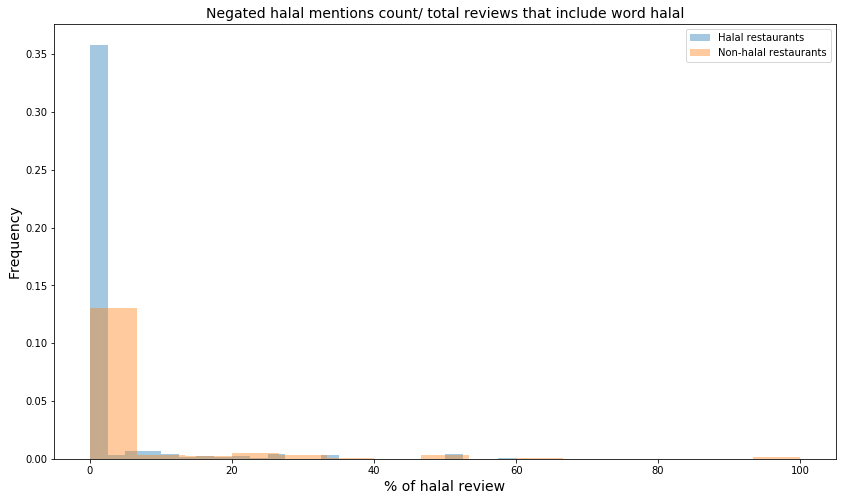

In [32]:
# add halal_neg_percent feature 
# number of negated halal mention divided by total number of reviews that include the word halal
grouped_reviews_df['halal_negation_percent'] = grouped_reviews_df['halal_negation_count'] / grouped_reviews_df['halal_review_count']

# plot distribution for halal vs non-halal restaurants
halal_target = grouped_reviews_df[grouped_reviews_df['halal']]['halal_negation_percent']
non_halal_target = grouped_reviews_df[~grouped_reviews_df['halal']]['halal_negation_percent']
fig = plt.figure(figsize=(14,8))
g1 = sns.distplot(halal_target*100, kde=False, norm_hist=True)
g2 = sns.distplot(non_halal_target*100, kde=False, norm_hist=True)
g1.set_title('Negated halal mentions count/ total reviews that include word halal', size=14)
g1.set_xlabel('% of halal review', size=14)
g1.set_ylabel('Frequency', size=14)
plt.legend(labels=['Halal restaurants','Non-halal restaurants'], prop={'size': 10})
plt.show()

## 8. Pickle dataframe with all features

In [33]:
grouped_reviews_df.columns

Index(['review_text', 'review_date', 'halal_review_count', 'restaurant_name',
       'total_review_count', 'halal', 'halal_in_name', 'halal_review_percent',
       'doc', 'halal_relevant_count', 'halal_relevant', 'halal_negation_count',
       'halal_negation', 'halal_truck_count', 'halal_truck',
       'non_halal_relevant_count', 'non_halal_relevant', 'creekstone_count',
       'creekstone', 'hala_bacon_count', 'halal_bacon',
       'halal_negation_percent'],
      dtype='object')

In [34]:
# file_name4 = os.getcwd() + '/restaurant_cat_and_num.pkl'
# grouped_reviews_df.drop(['review_text', 'review_date', 'restaurant_name', 'doc'] ,axis=1).to_pickle(file_name4)

## 9. Pickle whole dataframe if needed later

In [35]:
file_name5 = os.getcwd() + '/features_draft_v2.2.pkl'
grouped_reviews_df.to_pickle(file_name5)